In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits
import sys

from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "64"

In [3]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")

In [4]:
nside = 2048; lmax = 2048

comp = "IQU"

spectra_components = ["TT", "EE", "BB"]

datadir="/global/cscratch1/sd/jianyao/Dust/"

In [5]:
planck_mask_filename = "/global/cscratch1/sd/jianyao/Dust/" + "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
planck_mask_80 = hp.read_map(planck_mask_filename, ["GAL080"])
planck_mask_90 = hp.read_map(planck_mask_filename, ["GAL090"])

# fit the power law of the final map from the small iqu case

In [4]:
IQU_ws = hp.read_map('/global/cscratch1/sd/jianyao/Dust/dust_gnilc_hybrid_out_nside2048_float32.fits', field = None) 
# the final map with small scales generated in small iqu domain, from Peppe's notebook

In [5]:
ell, cl_norm, cl_dust_IQU_ws  = run_anafast(IQU_ws, lmax)

- fit the TT in the range of [500, 900]; use TT also for EE and BB (green lines)

B-to-E ratio w/ fitted power law at l= 700 , 12.772853758341556
A_fit {'TT': 18894961.66600253, 'EE': 21336.97322047721, 'BB': 272534.0385908055}
gamma_fit {'TT': -1.3235658240112926, 'EE': -1.1462077070614032, 'BB': -1.6109290085038728}
A_fit {'TT': 18894961.66600253, 'EE': 68192.09656962956, 'BB': 41480.53211947737}
gamma_fit {'TT': -1.3235658240112926, 'EE': -1.3235658240112926, 'BB': -1.3235658240112926}
B-to-E ratio w/ TT power law at l= 700 , 0.6082894383093567


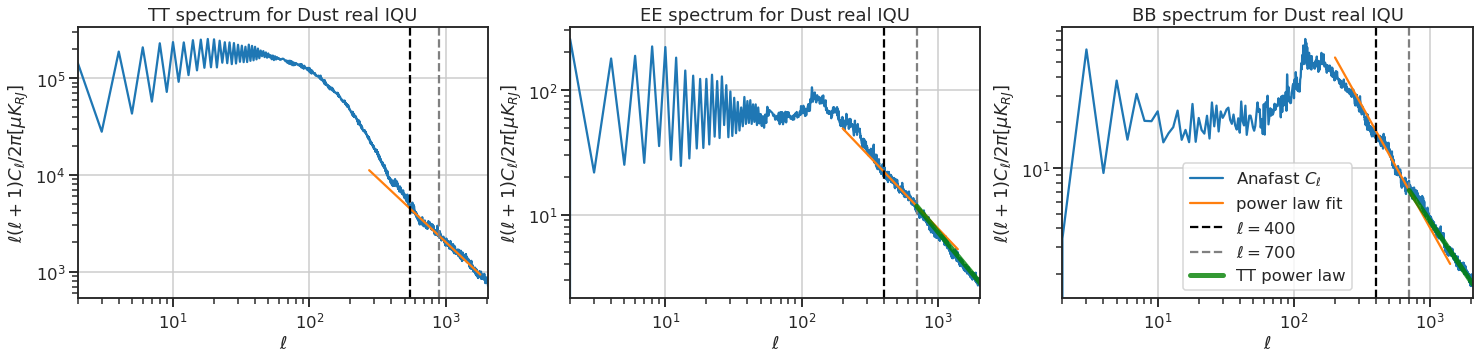

In [31]:
ell_fit_low = {"TT":550, "EE":400, "BB":400}
ell_fit_high = {"TT":900, "EE":700, "BB":700}
  
A_fit, gamma_fit = fit_ps(cl_dust_IQU_ws, lmax)

- fit the power-law at the high ell region,  but use it at a larger scale!!!

In [10]:
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}

In [12]:
output_nside = 2048 
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [17]:
np.random.seed(8192)
# filter small scales
small_scales_input_cl = [
    1
    * model(output_ell, A_fit[pol], gamma_fit[pol])
    * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
    / output_cl_norm
    for pol in spectra_components
]

<ipython-input-13-56cc0d3e0b39>:55: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [42]:
np.save('/global/cscratch1/sd/jianyao/Dust/small_scales_cl.npy', small_scales_input_cl)

## power law used to generate small scales realizations

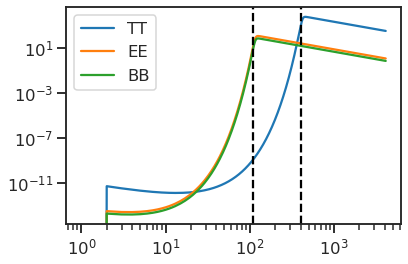

In [30]:
ell = np.arange(len(small_scales_input_cl[0]))
plt.loglog(ell, ell*(ell+1)/2/np.pi*small_scales_input_cl[0], label = 'TT')
plt.loglog(ell, ell*(ell+1)/2/np.pi*small_scales_input_cl[1], label = 'EE')
plt.loglog(ell, ell*(ell+1)/2/np.pi*small_scales_input_cl[2], label = 'BB')

plt.axvline(400, ls = '--', color = 'k')
plt.axvline(110, ls = '--', color = 'k')
plt.legend()

# modulate the small scales 

In [9]:
# logpoltens map of orignal map with monopole subtracted. from Peppe's notebook
log_pol_tens_varres = hp.read_map('/global/cscratch1/sd/jianyao/Dust/dust_gnilc_logpoltens_varres_nomono.fits', field = None)
dust_IQU = log_pol_tens_to_map(log_pol_tens_varres)

In [13]:
ls = get_large_scales(dust_IQU, lmax, spectra_components, ell_fit_high, output_nside)
log_ls = get_large_scales(log_pol_tens_varres, lmax, spectra_components, ell_fit_high, output_nside)

In [14]:
ss_cl = np.load('/global/cscratch1/sd/jianyao/Dust/small_scales_cl.npy')
ss_cl_pt = hp.read_cl('/global/cscratch1/sd/jianyao/Dust/small_scales_logpoltens_cl_lmax4096.fits') # extended small scales cls of iqu, from Peppe's notebook
ss_cl = np.row_stack((ss_cl, np.zeros(output_lmax + 1)))
ss_cl_pt = np.row_stack((ss_cl_pt, np.zeros(output_lmax + 1)))

In [15]:
# modulation in small IQU case, from Peppe's notebook
modulate_amp = hp.read_map(datadir + f"modulate_amp_nside{nside}.fits")
modulate_amp_pol = hp.read_map(datadir + f"modulate_amp_pol_nside{nside}.fits")

In [16]:
log_ss = hp.synfast(ss_cl_pt, lmax=output_lmax, new=True,nside=output_nside) # maps generated from small iqu cls
ss = hp.synfast(ss_cl, lmax=output_lmax, new=True,nside=output_nside) #maps generated from IQU cls

/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [17]:
log_ss_mod = np.zeros_like(ss)
log_ss_mod[0] =log_ss[0]*modulate_amp
log_ss_mod[1:] = log_ss[1:]*modulate_amp_pol

log_map_out_mod = log_ls + log_ss_mod
IQU_log_map_out_mod = log_pol_tens_to_map(log_map_out_mod)

In [18]:
# modulation in big IQU case
ismooth = hp.smoothing(dust_IQU[0], fwhm=np.radians(5), lmax=lmax)
new_mod = minmax(ismooth, 0, 6)

In [19]:
Map2 = np.zeros_like(ss)
Map2[1:] = ls[1:] + ss[1:]*new_mod*1.7065 # QU
Map2[0] = ls[0] + ss[0]*new_mod*1.0955 # I
# these coefficients are calculated from the cl_IQU_iqu/{cl_IQU(without modulation)}|at small scales.

# Power spectra

In [20]:
ell_hp, cl_norm_hp, cl2_hp = run_anafast(Map2, lmax = lmax)

ell, cl_norm, cl2_na = run_namaster(Map2, mask=planck_mask_80, lmax=lmax, nlbins = 10)
ell, cl_norm, cl2_na_90 = run_namaster(Map2, mask=planck_mask_90, lmax=lmax, nlbins = 10)

In [21]:
ell_hp, cl_norm_hp, cl_IQU_iqu_hp = run_anafast(IQU_log_map_out_mod, lmax = lmax)
ell, cl_norm, cl_IQU_iqu_na = run_namaster(IQU_log_map_out_mod, mask=planck_mask_80, lmax=lmax, nlbins = 10)
ell, cl_norm, cl_IQU_iqu_na_90 = run_namaster(IQU_log_map_out_mod, mask=planck_mask_90, lmax=lmax, nlbins = 10)

Text(0.5, 0.98, 'Green: IQU; Red: IQU_iqu; 100%, 90%, 80%, 50%; Direction 1')

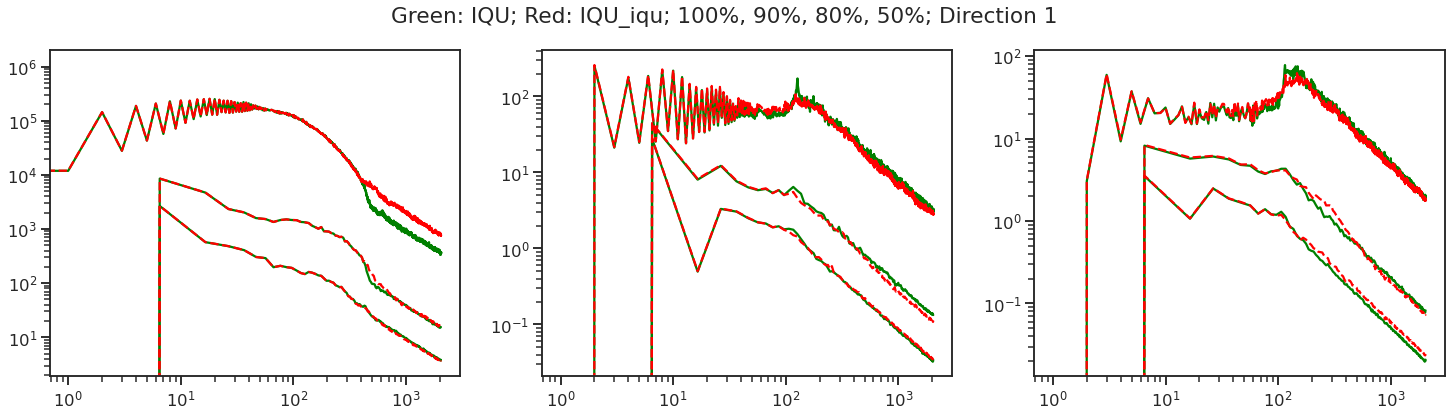

In [22]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl2_hp[modes[i]], 'g-', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl2_na_90[modes[i]], 'g-',label = '90%')
    ax.loglog(ell,  cl_norm*cl2_na[modes[i]], 'g-',label = '80%')
    # ax.loglog(ell,  cl_norm*cl2_na_50[modes[i]], 'g-',label = '50%')
    
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_hp[modes[i]], 'r--', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_90[modes[i]], 'r--', label = '90%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na[modes[i]], 'r--', label = '80%')
    # ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_50[modes[i]], 'r--', label = '50%')
fig.suptitle('Green: IQU; Red: IQU_iqu; 100%, 90%, 80%, 50%; Direction 1')

# definitions

In [7]:
def fit_ps(cl, lmax, EB_alone = False):

    A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
    ell = np.arange(lmax + 1)

    plt.figure(figsize=(25,5))

    for ii, pol in enumerate(spectra_components):
        plt.subplot(131+ii)
        xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
        ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
        (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
        A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))

        plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="Anafast $C_\ell$")
        ells = ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2]
        plt.plot(ells, model(ells, A_fit[pol], gamma_fit[pol]), label="power law fit")

        plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
        plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
        plt.grid()
        plt.title(f"{pol} spectrum for Dust real IQU" )

        plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(2, lmax)
        # print(f"Spectral index from fit for {pol}={gamma_fit[pol]}")
    print(f"B-to-E ratio w/ fitted power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 

    print('A_fit', A_fit)
    print('gamma_fit', gamma_fit)
    
    if EB_alone:
        
        return A_fit, gamma_fit
    
    else:       
        for ii, pol in enumerate(spectra_components[1:] ):
            #we change the EE and BB power laws 
            A_fit[pol] =A_fit[pol]*  ell_fit_high[pol]**( gamma_fit[pol ] - gamma_fit['TT' ] ) 
            gamma_fit[pol] = gamma_fit['TT'] 
            plt.subplot(132+ii)

            ells = ell[ell_fit_high[pol] :ell_fit_high[pol]*10]
            plt.plot(ells, model(ells, A_fit[pol], gamma_fit[pol]),linewidth=5, alpha=.8, color='g', label="TT power law")

        print('A_fit', A_fit)
        print('gamma_fit', gamma_fit)  
        print(f"B-to-E ratio w/ TT power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 
        plt.legend() 

        return A_fit, gamma_fit

def model(ell, A, gamma):
    out = A * ell ** gamma
    if ell[0] == 0:
        out[0:2] = 0
    return out

In [8]:
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m

def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens

def rescale_min_max(img, a=-1, b=1, return_min_max=False):
    img_resc = (b-a)*(img-np.min(img))/(np.max(img)-np.min(img))+a
    if return_min_max:
        return img_resc, np.min(img), np.max(img)
    else:
        return img_resc

def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))
  
def get_large_scales(maps_input, lmax, spectra_components, ells,output_nside):
  
    alm_IQU_fullsky = hp.map2alm(maps_input, lmax=lmax, use_pixel_weights=True)
    LS_alm = np.empty_like(alm_IQU_fullsky)
    ell = np.arange(lmax + 1)

    for ii, pol in enumerate(spectra_components):

        sig_func = sigmoid(ell, x0=ells[pol], width=ells[pol] / 10)

        LS_alm[ii] = hp.almxfl(alm_IQU_fullsky[ii], (1.0 - sig_func) ** 0.2) 

    ls = hp.alm2map(LS_alm, nside=output_nside)

    return ls

def get_small_scales(maps_input, lmax, spectra_components, ells,output_nside):
  
    alm_IQU_fullsky = hp.map2alm(maps_input, lmax=lmax, use_pixel_weights=True)
    SS_alm = np.empty_like(alm_IQU_fullsky)
    ell = np.arange(lmax + 1)

    for ii, pol in enumerate(spectra_components):

        sig_func = sigmoid(ell, x0=ells[pol], width=ells[pol] / 10)

        SS_alm[ii] = hp.almxfl(alm_IQU_fullsky[ii], sig_func) 

    ss = hp.alm2map(SS_alm, nside=output_nside)

    return ss

def run_anafast(m, lmax):
    """
    two cases: 1) IQU; 2) I only
    """
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    
    if len(m) == 3: 
        cl["TT"] = clanaf[0]; cl["EE"] = clanaf[1]
        cl["BB"] = clanaf[2]; cl["TE"] = clanaf[3]
    
    elif m.ndim == 1:
        cl["TT"] = clanaf
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

def run_namaster(m, mask, lmax, nlbins=1):
    """
    Compute C_ell with NaMaster
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl